Shape: (388, 13)
Age                             int64
Gender                         object
Marital Status                 object
Occupation                     object
Monthly Income                 object
Educational Qualifications     object
Family size                     int64
latitude                      float64
longitude                     float64
Pin code                        int64
Output                         object
Feedback                       object
Unnamed: 12                    object
dtype: object
   Age  Gender Marital Status Occupation  Monthly Income  \
0   20  Female         Single    Student       No Income   
1   24  Female         Single    Student  Below Rs.10000   
2   22    Male         Single    Student  Below Rs.10000   
3   22  Female         Single    Student       No Income   
4   22    Male         Single    Student  Below Rs.10000   

  Educational Qualifications  Family size  latitude  longitude  Pin code  \
0              Post Graduate          

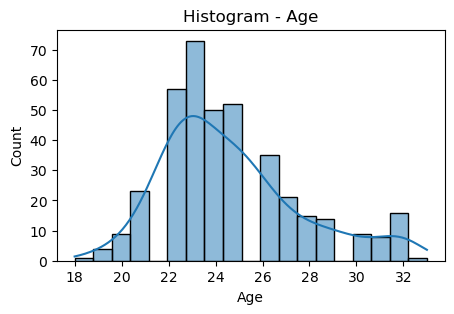

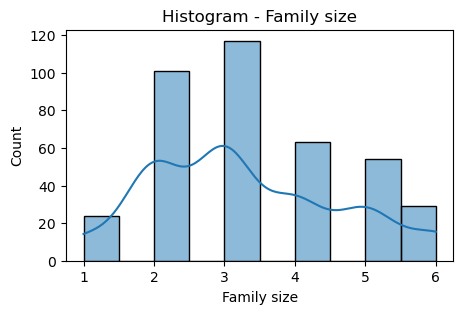

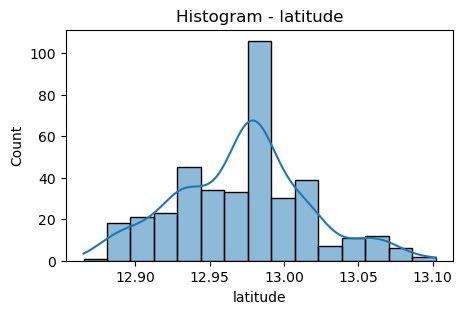

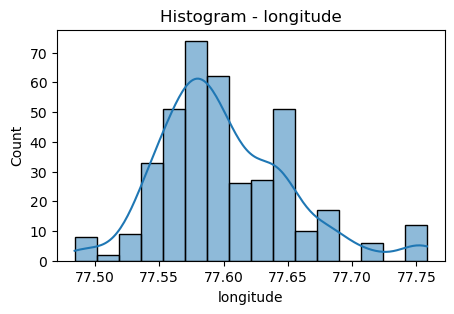

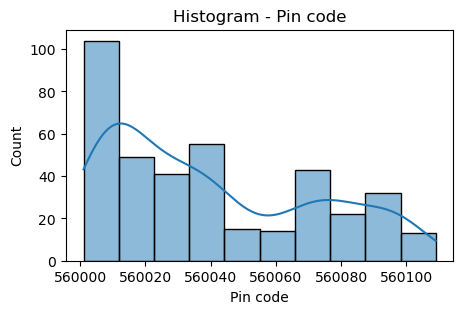

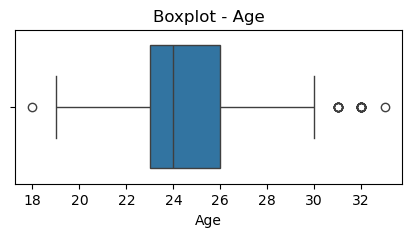

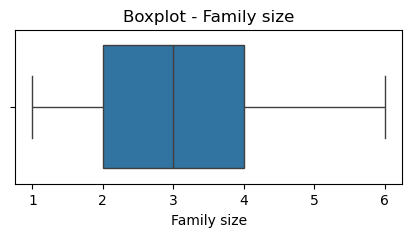

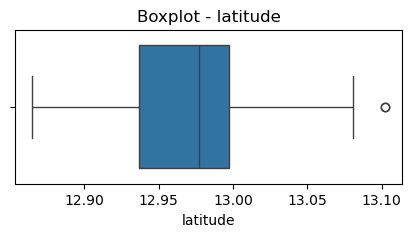

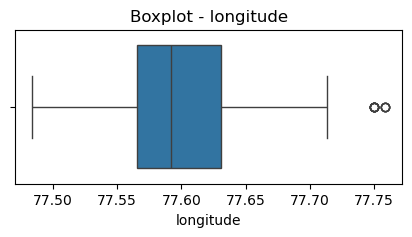

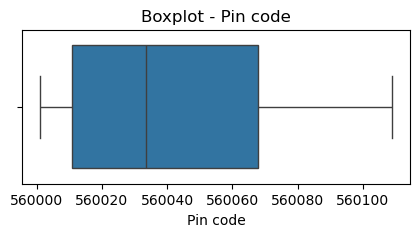

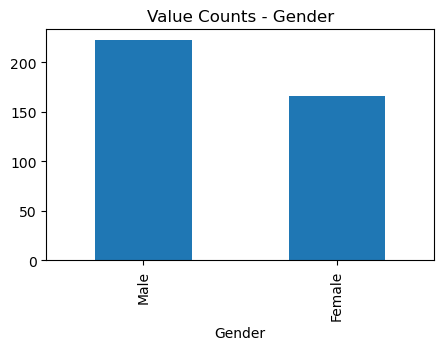

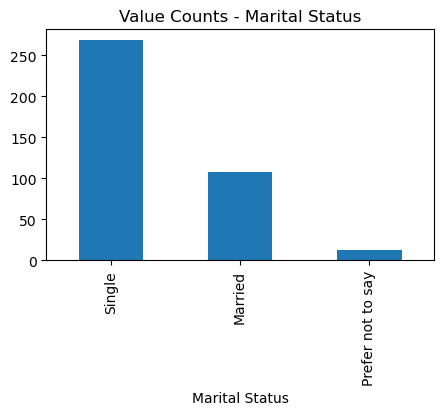

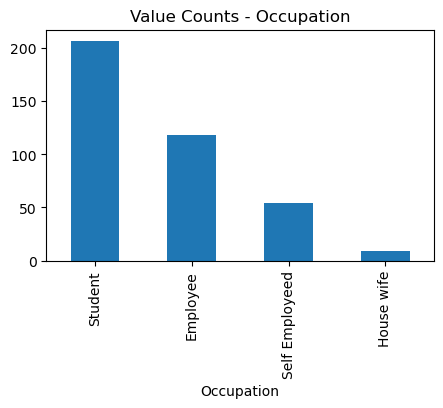

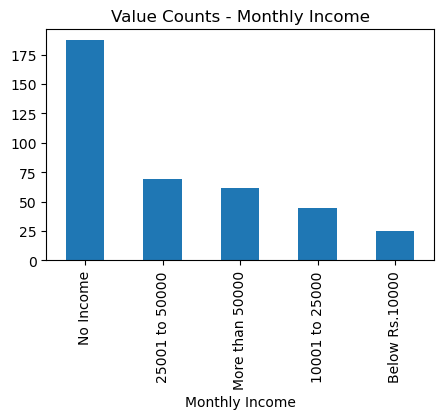

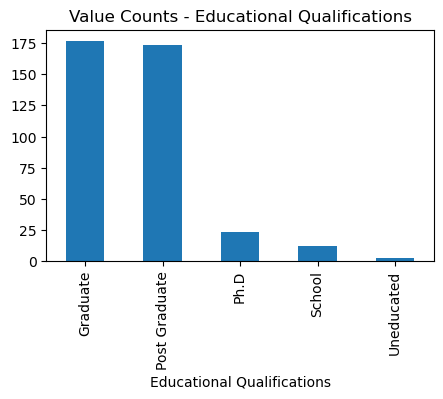

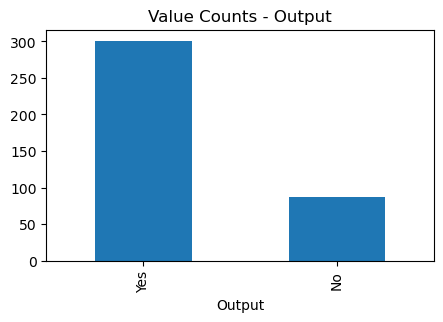

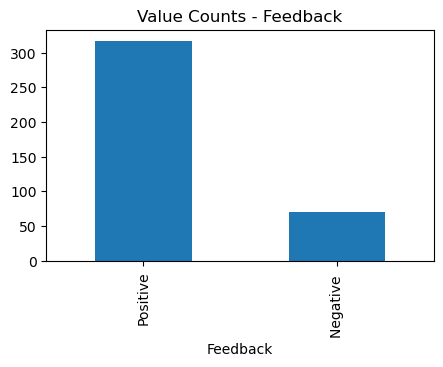

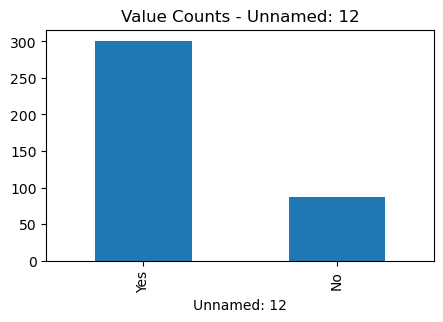

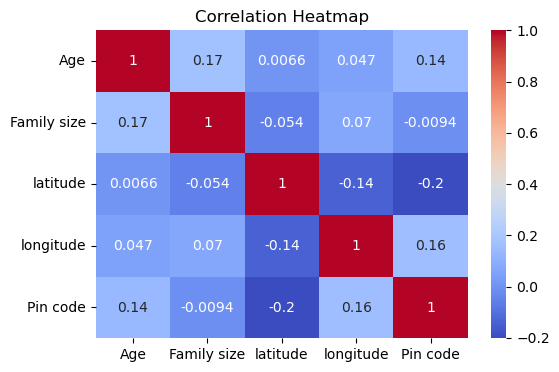

In [2]:
# STAGE 1 – EDA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load dataset
df = pd.read_csv("data/onlinefoods.csv")  # ganti path sesuai lokasi file

# 2. Info awal
print("Shape:", df.shape)
print(df.dtypes)
print(df.head())

# 3. Cek missing values
print("\nMissing values:")
print(df.isna().sum())

# 4. Descriptive statistics numeric
print("\nDescriptive stats:")
print(df.describe())

# 5. List numeric & categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", cat_cols)

# 6. Visualisasi numeric (histogram)
for col in numeric_cols:
    plt.figure(figsize=(5,3))
    sns.histplot(df[col], kde=True)
    plt.title(f"Histogram - {col}")
    plt.show()

# 7. Visualisasi numeric (boxplot)
for col in numeric_cols:
    plt.figure(figsize=(5,2))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot - {col}")
    plt.show()

# 8. Visualisasi categorical (bar plot)
for col in cat_cols:
    plt.figure(figsize=(5,3))
    df[col].value_counts().plot(kind="bar")
    plt.title(f"Value Counts - {col}")
    plt.show()

# 9. Korelasi numeric
if len(numeric_cols) > 1:
    plt.figure(figsize=(6,4))
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()

In [8]:
# STAGE 2 – PREPROCESSING

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. Load dataset
df = pd.read_csv("data/onlinefoods.csv")

# 2. Bersihkan whitespace di semua kolom object
for col in df.select_dtypes(include=['object','category']).columns:
    df[col] = df[col].astype(str).str.strip()

# 3. Drop kolom noise
if 'Unnamed: 12' in df.columns:
    df.drop(columns=['Unnamed: 12'], inplace=True)

# 4. Pastikan kolom Output bersih & mapping biner
df['Output'] = df['Output'].str.lower().map({
    'yes': 1,
    'no': 0
})

# Hapus baris yang Output-nya NaN (jika ada)
df = df.dropna(subset=['Output'])
df['Output'] = df['Output'].astype(int)

# 5. Tentukan kolom numerik & kategorikal
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

if 'Output' in num_cols:
    num_cols.remove('Output')
if 'Output' in cat_cols:
    cat_cols.remove('Output')

# 6. Imputasi missing values
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# 7. Drop kolom ID/high-cardinality
if 'Pin code' in df.columns:
    df.drop(columns=['Pin code'], inplace=True)
    num_cols = [c for c in num_cols if c != 'Pin code']

# 8. One-hot encoding
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# 9. Scaling numeric features
num_cols_scaled = [c for c in num_cols if c in df_encoded.columns]
scaler = StandardScaler()
df_encoded[num_cols_scaled] = scaler.fit_transform(df_encoded[num_cols_scaled])

# 10. Split train-test
X = df_encoded.drop(columns=['Output'])
y = df_encoded['Output']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Distribusi target (train):")
print(y_train.value_counts(normalize=True))
print("Distribusi target (test):")
print(y_test.value_counts(normalize=True))



Train shape: (310, 19)
Test shape: (78, 19)
Distribusi target (train):
Output
1    0.774194
0    0.225806
Name: proportion, dtype: float64
Distribusi target (test):
Output
1    0.782051
0    0.217949
Name: proportion, dtype: float64



=== Logistic Regression ===
Accuracy : 0.7949
Precision: 0.8947
Recall   : 0.8361
F1-score : 0.8644
Confusion Matrix:
[[11  6]
 [10 51]]
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.65      0.58        17
           1       0.89      0.84      0.86        61

    accuracy                           0.79        78
   macro avg       0.71      0.74      0.72        78
weighted avg       0.81      0.79      0.80        78


=== Random Forest ===
Accuracy : 0.9359
Precision: 0.9375
Recall   : 0.9836
F1-score : 0.9600
Confusion Matrix:
[[13  4]
 [ 1 60]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.76      0.84        17
           1       0.94      0.98      0.96        61

    accuracy                           0.94        78
   macro avg       0.93      0.87      0.90        78
weighted avg       0.94      0.94      0.93        78


=== SVM (RBF) ===
Accuracy : 

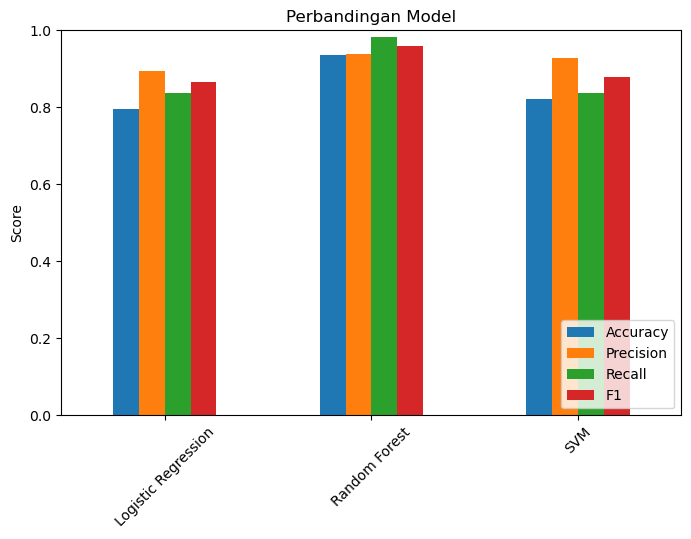


Best params RF: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best F1 RF: 0.921150514719813

Cross-validation F1 scores (RF best): [0.94949495 0.95049505 0.90566038 0.87378641 0.92631579]
Mean CV F1: 0.921150514719813


In [9]:
# STAGE 3 – MODEL TRAINING & COMPARISON

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Logistic Regression ---
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

# --- 2. Random Forest ---
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# --- 3. Support Vector Machine (RBF kernel) ---
svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Fungsi evaluasi
def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n=== {model_name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    return acc, prec, rec, f1

# Evaluasi tiap model
results = {}
results['Logistic Regression'] = evaluate_model(y_test, y_pred_log, "Logistic Regression")
results['Random Forest'] = evaluate_model(y_test, y_pred_rf, "Random Forest")
results['SVM'] = evaluate_model(y_test, y_pred_svm, "SVM (RBF)")

# --- 4. Visualisasi perbandingan metrik ---
results_df = pd.DataFrame(results, index=['Accuracy','Precision','Recall','F1']).T
results_df.plot(kind='bar', figsize=(8,5))
plt.title("Perbandingan Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.show()

# --- 5. Hyperparameter Tuning dengan GridSearchCV (contoh Random Forest) ---
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)
print("\nBest params RF:", grid_rf.best_params_)
print("Best F1 RF:", grid_rf.best_score_)

# --- 6. Cross-validation untuk model terbaik ---
best_rf = grid_rf.best_estimator_
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='f1')
print("\nCross-validation F1 scores (RF best):", cv_scores)
print("Mean CV F1:", cv_scores.mean())

In [12]:
# STAGE 4 – MODEL SELECTION & DEPLOYMENT

import joblib
import pandas as pd

# === 1. Pilih model terbaik dari Stage 3 ===
# Misal hasil evaluasi Stage 3 menunjukkan Random Forest terbaik
best_model = best_rf  # hasil best_rf dari GridSearchCV Stage 3

# Simpan model dan scaler
joblib.dump(best_model, "model_rf.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Model dan scaler berhasil disimpan.")

# === 2. Contoh penggunaan model yang disimpan ===
# Muat ulang model dan scaler
loaded_model = joblib.load("model_rf.pkl")
loaded_scaler = joblib.load("scaler.pkl")

# Prediksi 1 baris data tanpa warning
feature_names = X_train.columns
sample_df = pd.DataFrame([X_test.iloc[0].values], columns=feature_names)
pred = loaded_model.predict(sample_df)
print("Prediksi sample:", pred)


Model dan scaler berhasil disimpan.
Prediksi sample: [1]
